# Cone-beam tomographic reconstruction: Chambolle-Pock algorithms

In [18]:
import ctdata
from pyastra import Projector
from algorithm import ChanGolubMullet, ChambollePock
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from jmutility import show_slices, slicing
import time

In [19]:
figsize=(10, 4)

## CT data set
GATE simulated data

In [20]:
d = ctdata.sets[14]
d.load()

## Initialize ASTRA projector

In [21]:
# Parameters
det_row_count, num_proj, det_col_count = d.shape
num_voxel = (det_col_count, det_col_count, det_row_count)
# voxel_size = 1
voxel_size = 2 * d.roi_cubic_width_mm / num_voxel[0]
source_origin = d.distance_source_origin_mm / voxel_size
origin_detector = d.distance_origin_detector_mm / voxel_size
angles = d.angles_rad
det_col_spacing = d.detector_width_mm / det_col_count / voxel_size
det_row_spacing = det_col_spacing

# Projector instance
projector = Projector(num_voxel=num_voxel,
                           det_row_count=det_row_count, det_col_count=det_col_count,
                           source_origin=source_origin, origin_detector=origin_detector,
                           det_row_spacing=det_row_spacing, det_col_spacing=det_col_spacing,
                           angles=angles)

## Initialize algorithm

In [5]:
cp = ChambollePock(projections=d.projections, projector=projector)

### Compute matrix norm of projector

In [6]:
norm_iter = 400
projector_norm = cp.matrix_norm(norm_iter, intermediate_results=True)

In [16]:
# after 100, 200, 300, 400 iterations
pn100 = 363.5708618164062500
pn200 = 363.5696411132812500
pn300 = 363.5696411132812500
pn400 = 363.5696411132812500
#print '%.16f' % projector_norm[99]
#print '%.16f' % projector_norm[199]
#print '%.16f' % projector_norm[299]
#print '%.16f' % projector_norm[399]

Matrix norm vs iteration

module://IPython.kernel.zmq.pylab.backend_inline


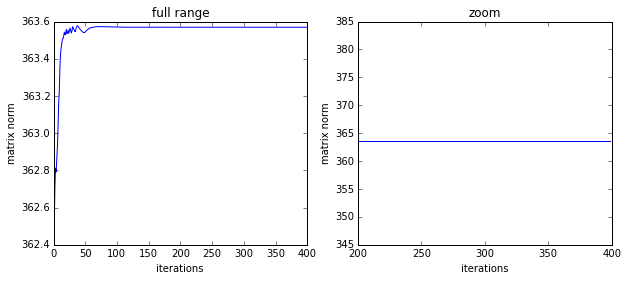

In [24]:
%matplotlib inline
# plt.switch_backend('qt4agg')
print plt.get_backend()
fig = plt.figure('Matrix norm of projector', figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('full range')
ax1.set_ylabel('matrix norm')
ax1.set_xlabel('iterations')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('zoom')
ax2.set_ylabel('matrix norm')
ax2.set_xlabel('iterations')
# full plot
l1, = ax1.plot(projector_norm)
# ROI plot
x = range(norm_iter/2, norm_iter)
l2, = ax2.plot(x, projector_norm[x])

## Unconstrained least-squares reconstruction
intermediate results: verbose=True

In [7]:
# switch backend for verbosity to display intermediate results
plt.switch_backend('qt4agg')
(u, p, cpd, l2atp) = cp.least_squares(50, L=pn400,
     verbose=True, non_negativiy_constraint=False)

/usr/local/lib/python2.7/dist-packages/matplotlib/backend_bases.py:2399: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [29]:
proj_shape = cp.K.projection_shape
proj_size = cp.K.projection_data.size
vol_shape = cp.K.volume_shape
vol_size = cp.K.volume_data.size

### Convergence measures

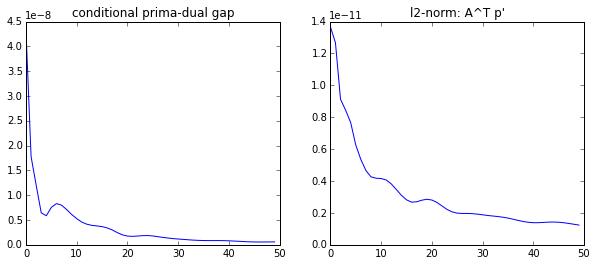

In [30]:
%matplotlib inline
fig = plt.figure('Convergence', figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('conditional prima-dual gap')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("l2-norm: A^T p'")
l1, = ax1.plot(cpd/vol_size)
l2, = ax2.plot(l2atp/proj_size)

### Ortho-slices of reconstructed volume

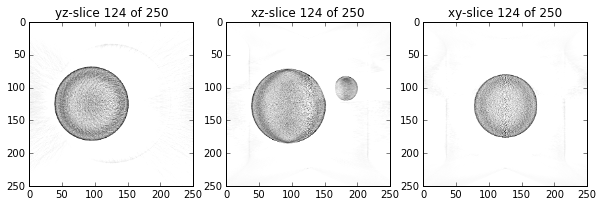

In [35]:
fig_u = show_slices(u, fig_name='final reconstruction u', figsize=figsize)

### Ortho-slices of dual variable p

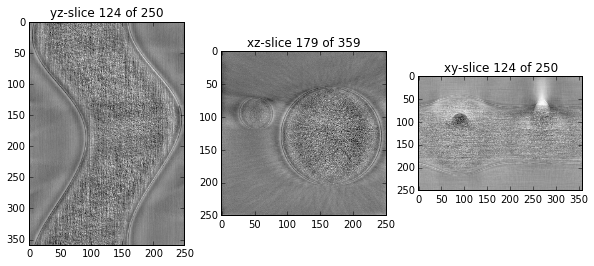

In [32]:
fig_p = show_slices(p, fig_name='dual variable p', figsize=figsize)

In [33]:
# Animtated slicing, probably crashing the notebook
# slicing(u)

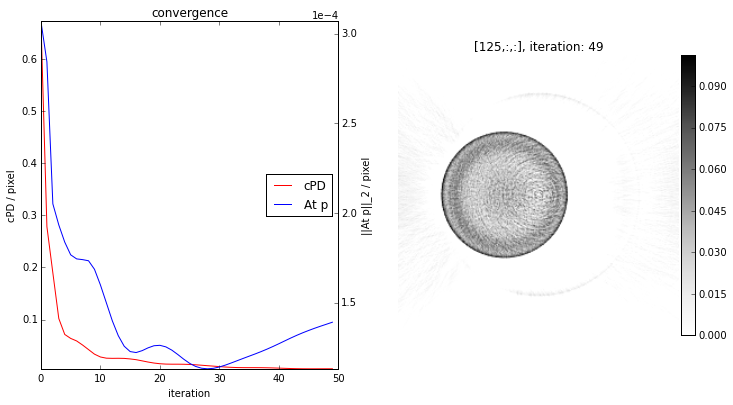

In [34]:
plt.switch_backend('qt4agg')
(un, pn, cpdn, l2atpn) = cp.least_squares(50, L=pn200,
     verbose=True, non_negativiy_constraint=True)

### Ortho-slices of reconstructed volume

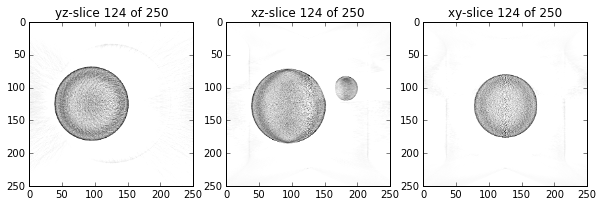

In [36]:
fig_u = show_slices(u, fig_name='final reconstruction u', figsize=figsize)

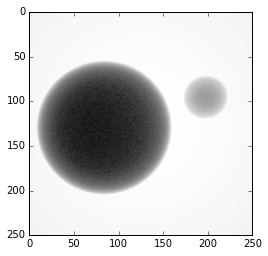

In [38]:
plt.switch_backend('qt4agg')

fig = plt.figure('Animated slicing')

nn = 0
im = plt.imshow(d.projections[:, nn, :], cmap=plt.get_cmap('Greys'))

def updatefig(*args) :
    global nn
    nn += 1
    nn = np.mod(nn, d.shape[1])
    im = plt.imshow(d.projections[:, nn, :], cmap=plt.get_cmap('Greys'))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=10, blit=True)
# plt.show(block=False)
plt.show()